# **Elementary Reinforcement Learning**

Objectives: understanting the usage of environments in the [OpenAI Gym](https://www.gymlibrary.dev/) framework and  implement basic exploration/exploitation RL algorithms

1.   Manage to create custom environments from the OpenAI Gym framework
2.   Exploration vs Exploitation (Multi-armed Bandit)



Install needed Python packages

In [ ]:
!pip install pygame gym numpy

# test

Import needed Python packages

In [ ]:
import gym
from gym import spaces
import pygame
import numpy as np

Mount Google Drive for saving results (not needed if running the notebook locally)

In [ ]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"         # default location for the drive

drive.mount(ROOT)              # we mount the google drive at /content/drive

Mounted at /content/drive


# **1) Create Custom Environments**


## Definition of a simple grid environment
The agent needs to reach a target location in the grid represented by the target.
For the documentation of the `gym.Env` class visit: https://www.gymlibrary.dev/api/core/#gym-env

Implemented methods for this class are:

*   `__init__` needed for setting all basic variables of the environment
*   `step` and `reset` for respectively making a step into the agent-environment loop and resetting to initial state
*   `render` needed for visualization purposes
*   `_render_frame` private method for rendering frames
* `_get_obs` and `_get_info` are private methods needed for returning observations and info

The environment for a squared grid of size 5 looks like this:

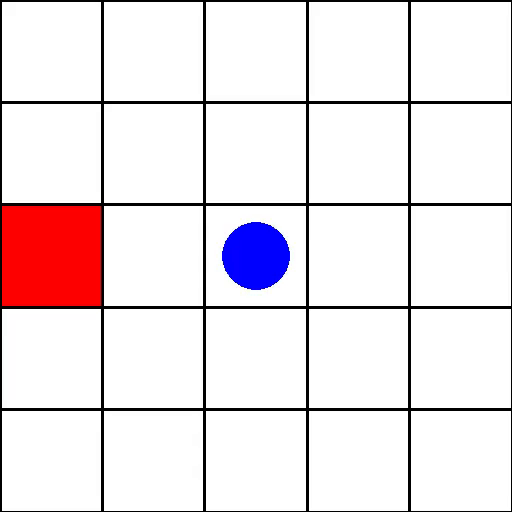

In [ ]:
class GridWorldEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None, size=5):
        self.size = size  # The size of the square grid
        self.window_size = 512  # The size of the PyGame window

        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`}^2, i.e. MultiDiscrete([size, size]).
        self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(0, size - 1, shape=(2,), dtype=int),
                "target": spaces.Box(0, size - 1, shape=(2,), dtype=int),
            }
        )

        # We have 4 actions, corresponding to "right", "up", "left", "down"
        self.action_space = spaces.Discrete(4)

        """
        The following dictionary maps abstract actions from `self.action_space` to
        the direction we will walk in if that action is taken.
        I.e. 0 corresponds to "right", 1 to "up" etc.
        """
        self._action_to_direction = {
            0: np.array([1, 0]),
            1: np.array([0, 1]),
            2: np.array([-1, 0]),
            3: np.array([0, -1]),
        }

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None

    # Private method to get observations
    def _get_obs(self):
        return {"agent": self._agent_location, "target": self._target_location}

    # Private method to get info
    def _get_info(self):
        return {"distance": np.linalg.norm(self._agent_location - self._target_location, ord=1)}

    # Reset method for the environment
    def reset(self, seed=None, options=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        # Choose the agent's location uniformly at random
        self._agent_location = self.np_random.integers(0, self.size, size=2, dtype=int)

        # We will sample the target's location randomly until it does not coincide with the agent's location
        self._target_location = self._agent_location
        while np.array_equal(self._target_location, self._agent_location):
            self._target_location = self.np_random.integers(
                0, self.size, size=2, dtype=int
            )

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info

    # Step method for the environment
    def step(self, action):
        # Map the action (element of {0,1,2,3}) to the direction we walk in
        direction = self._action_to_direction[action]
        # We use `np.clip` to make sure we don't leave the grid
        self._agent_location = np.clip(
            self._agent_location + direction, 0, self.size - 1
        )
        # An episode is done iff the agent has reached the target
        terminated = np.array_equal(self._agent_location, self._target_location)
        reward = 1 if terminated else 0  # Binary sparse rewards
        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, reward, terminated, False, info

    # Render method for visualization
    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        pix_square_size = (
            self.window_size / self.size
        )  # The size of a single grid square in pixels

        # First we draw the target
        pygame.draw.rect(
            canvas,
            (255, 0, 0),
            pygame.Rect(
                pix_square_size * self._target_location,
                (pix_square_size, pix_square_size),
            ),
        )
        # Now we draw the agent
        pygame.draw.circle(
            canvas,
            (0, 0, 255),
            (self._agent_location + 0.5) * pix_square_size,
            pix_square_size / 3,
        )

        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=3,
            )
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )


Imports and functions for recording/showing videos for random policy on `GridEnv`

In [ ]:
from gym.wrappers import RecordVideo
from pathlib import Path
import base64
from IPython import display as ipythondisplay

In [ ]:
# Set up fake display; otherwise rendering will fail on Google Colab
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [ ]:
def record_video_rand_gwenv(env, video_length=0, step_trigger=None, episode_trigger=None,  prefix='', video_folder='videos/'):

  video_env = RecordVideo(env,
                         video_folder=video_folder,
                         episode_trigger=episode_trigger,
                         step_trigger=step_trigger,
                         video_length=video_length,
                         name_prefix=prefix,
                         new_step_api=True
                         )

  observation, info = video_env.reset()

  step = 0
  ep = 0

  while True:

    if _iterate_condition(step, ep, video_length=video_length, step_trigger=step_trigger, episode_trigger=episode_trigger):

      observation, reward, terminated, _, info = video_env.step(env.action_space.sample())
      step += 1

      if terminated:
        observation, info = video_env.reset()
        ep += 1
        step = 0

    else:
      break

  video_env.close()

# Utility function for checking stopping condition
def _iterate_condition(step, ep, video_length=0, step_trigger=None, episode_trigger=None):

  if video_length is not 0:
    go = True if step < video_length else False
    return go

  if step_trigger is not None:
    go = step_trigger(step)
    return go

  if episode_trigger is not None:
    go = episode_trigger(ep)
    return go

<>:37: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:37: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-8-20cc7e5af827>:37: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if video_length is not 0:


In [ ]:
def show_videos(video_path='', prefix=''):
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

Record video of ten steps for random policy on `GridEnv` environment

In [ ]:
import sys
import os

is_colab = 'google.colab' in sys.modules
root_dir ='drive/MyDrive/WinterSchoolRL2024' if is_colab else '.'

In [ ]:
video_folder = os.path.join(root_dir, 'Videos')
os.makedirs(video_folder, exist_ok=True)

prefix = 'gw_random'
grid_size = 5

# set video_length, episode_trigger, step_trigger
gwenv = GridWorldEnv(render_mode='rgb_array', size=grid_size)
record_video_rand_gwenv(gwenv,
                        video_length=0,
                        episode_trigger=lambda ep: (ep == 0),
                        step_trigger=None,
                        prefix=prefix,
                        video_folder=video_folder)

/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/WinterSchoolRL2024/Videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Play recorded video

In [ ]:
show_videos(video_folder, prefix=prefix)

## Extension of `GridEnv` into `GridWorldBlindEnemyEnv`: adding another blind enemy agent

The task is to extend the previously defined environment into a more challenging scenario by inserting another agent that is going to eat our agent, if met. Precisely, the following rules should be satisfied:


*   The enemy agent should move randomly on the grid (i.e., the enemy does not know the position of our agent)
*   If our agent and enemy agent are on the same cell, the reward is -1 and the episode should terminate
* The starting positions for our and enemy agents should not coincide at episodes' start
* The enemy agent can't never reach the target location



In [ ]:
"""class GridWorldBlindEnemyEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None, size=5):
      pass

    def _get_obs(self):
        return None

    def _get_info(self):
        return None

    def reset(self, seed=None, options=None):
        return None

    def step(self, action):
        return None

    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        pass"""

class GridWorldBlindEnemyEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None, size=5):
        self.size = size  # The size of the square grid
        self.window_size = 512  # The size of the PyGame window

        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`}^2, i.e. MultiDiscrete([size, size]).
        self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(0, size - 1, shape=(2,), dtype=int),
                "enemy": spaces.Box(0, size - 1, shape=(2,), dtype=int),
                "target": spaces.Box(0, size - 1, shape=(2,), dtype=int),
            }
        )

        # We have 4 actions, corresponding to "right", "up", "left", "down"
        self.action_space = spaces.Discrete(4)

        """
        The following dictionary maps abstract actions from `self.action_space` to
        the direction we will walk in if that action is taken.
        I.e. 0 corresponds to "right", 1 to "up" etc.
        """
        self._action_to_direction = {
            0: np.array([1, 0]),
            1: np.array([0, 1]),
            2: np.array([-1, 0]),
            3: np.array([0, -1]),
        }

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None

    # Private method to get observations
    def _get_obs(self):
        return {"agent": self._agent_location, "enemy": self._enemy_location, "target": self._target_location}

    # Private method to get info
    def _get_info(self):
        return {"distance": np.linalg.norm(self._agent_location - self._target_location, ord=1)}

    # Reset method for the environment
    def reset(self, seed=None, options=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        # Choose the agent's location uniformly at random
        self._agent_location = self.np_random.integers(0, self.size, size=2, dtype=int)

        # We will sample the target's location randomly until it does not coincide with the agent's location
        self._target_location = self._agent_location
        while np.array_equal(self._target_location, self._agent_location):
            self._target_location = self.np_random.integers(
                0, self.size, size=2, dtype=int
            )

        # We will sample the enemy's location randomly until it does not coincide
        #   with the agent's location or the target location
        self._enemy_location = self._agent_location
        while (np.array_equal(self._enemy_location, self._agent_location) or
               np.array_equal(self._enemy_location, self._target_location)):
            self._enemy_location = self.np_random.integers(
                0, self.size, size=2, dtype=int
            )

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info

    # Step method for the environment
    def step(self, action):
        # Map the action (element of {0,1,2,3}) to the direction we walk in
        direction = self._action_to_direction[action]
        # We use `np.clip` to make sure we don't leave the grid
        self._agent_location = np.clip(
            self._agent_location + direction, 0, self.size - 1
        )

        # enemy moves randomly
        enemy_action = self.action_space.sample()
        enemy_direction = self._action_to_direction[enemy_action]
        # We use `np.clip` to make sure we don't leave the grid
        _new_enemy_location = np.clip(
            self._enemy_location + enemy_direction, 0, self.size - 1
        )

        if not np.array_equal(_new_enemy_location, self._target_location):
          self._enemy_location = _new_enemy_location

        # An episode is done iff the agent has reached the target or the enemy
        #   catches the agent
        if np.array_equal(self._agent_location, self._target_location):
          terminated = True
          reward = 1
        elif np.array_equal(self._agent_location, self._enemy_location): # enemy = target
          terminated = True
          reward = -1
        else: # game goes on (reward = 0)
          terminated = False
          reward = 0

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, reward, terminated, False, info

    # Render method for visualization
    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        pix_square_size = (
            self.window_size / self.size
        )  # The size of a single grid square in pixels

        # First we draw the target
        pygame.draw.rect(
            canvas,
            (255, 0, 0),
            pygame.Rect(
                pix_square_size * self._target_location,
                (pix_square_size, pix_square_size),
            ),
        )
        # Now we draw the agent
        pygame.draw.circle(
            canvas,
            (0, 0, 255),
            (self._agent_location + 0.5) * pix_square_size,
            pix_square_size / 3,
        )

        # Now we draw the enemy
        pygame.draw.circle(
            canvas,
            (0, 255, 0),
            (self._enemy_location + 0.5) * pix_square_size,
            pix_square_size / 3,
        )

        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=3,
            )
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Record and check videos to assert that the environment works correctly (hint: use previously defined functions)

In [ ]:
# TO COMPLETE
# set video_length, episode_trigger, step_trigger
gwenv = GridWorldBlindEnemyEnv(render_mode='rgb_array', size=grid_size)
record_video_rand_gwenv(gwenv,
                        video_length=0,
                        episode_trigger=lambda ep: (ep == 0),
                        step_trigger=None,
                        prefix=prefix,
                        video_folder=video_folder)

/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/WinterSchoolRL2024/Videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [ ]:
show_videos(video_folder, prefix=prefix)

## Extension of `GridWorldBlindEnemyEnv` into `GridWorldOracleEnemyEnv`: making the blind enemy agent more knwoledgable

An additional extension foresees the imporvement of the blind enemy agent into an oracle enemy agent (i.e., an enemy agent that knows the position of our agent). In this case, we modify one of the rules of the `GridWorldBlindEnemyEnv`:

*   The enemy agent should follow our agent on the grid (i.e., always making a step towards him)



In [ ]:
"""class GridWorldOracleEnemyEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None, size=5):
      pass

    def _get_obs(self):
        return None

    def _get_info(self):
        return None

    def reset(self, seed=None, options=None):
        return None

    def step(self, action):
        return None

    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        pass"""

"""class GridWorldBlindEnemyEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None, size=5):
      pass

    def _get_obs(self):
        return None

    def _get_info(self):
        return None

    def reset(self, seed=None, options=None):
        return None

    def step(self, action):
        return None

    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        pass"""

class GridWorldOracleEnemyEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None, size=5):
        self.size = size  # The size of the square grid
        self.window_size = 512  # The size of the PyGame window

        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`}^2, i.e. MultiDiscrete([size, size]).
        self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(0, size - 1, shape=(2,), dtype=int),
                "enemy": spaces.Box(0, size - 1, shape=(2,), dtype=int),
                "target": spaces.Box(0, size - 1, shape=(2,), dtype=int),
            }
        )

        # We have 4 actions, corresponding to "right", "up", "left", "down"
        self.action_space = spaces.Discrete(4)

        """
        The following dictionary maps abstract actions from `self.action_space` to
        the direction we will walk in if that action is taken.
        I.e. 0 corresponds to "right", 1 to "up" etc.
        """
        self._action_to_direction = {
            0: np.array([1, 0]),
            1: np.array([0, 1]),
            2: np.array([-1, 0]),
            3: np.array([0, -1]),
        }

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None

    # Private method to get observations
    def _get_obs(self):
        return {"agent": self._agent_location, "enemy": self._enemy_location, "target": self._target_location}

    # Private method to get info
    def _get_info(self):
        return {"distance": np.linalg.norm(self._agent_location - self._target_location, ord=1)}

    # Reset method for the environment
    def reset(self, seed=None, options=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        # Choose the agent's location uniformly at random
        self._agent_location = self.np_random.integers(0, self.size, size=2, dtype=int)

        # We will sample the target's location randomly until it does not coincide with the agent's location
        self._target_location = self._agent_location
        while np.array_equal(self._target_location, self._agent_location):
            self._target_location = self.np_random.integers(
                0, self.size, size=2, dtype=int
            )

        # We will sample the enemy's location randomly until it does not coincide
        #   with the agent's location or the target location
        self._enemy_location = self._agent_location
        while (np.array_equal(self._enemy_location, self._agent_location) or
               np.array_equal(self._enemy_location, self._target_location)):
            self._enemy_location = self.np_random.integers(
                0, self.size, size=2, dtype=int
            )

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info

    # Step method for the environment
    def step(self, action):
        # Map the action (element of {0,1,2,3}) to the direction we walk in
        direction = self._action_to_direction[action]
        # We use `np.clip` to make sure we don't leave the grid
        self._agent_location = np.clip(
            self._agent_location + direction, 0, self.size - 1
        )

        if np.array_equal(self._agent_location, self._enemy_location): # enemy = target
          terminated = True
          reward = -1

        else:
          # enemy moves knowledgably
          current_manhattan_distance = np.linalg.norm(self._agent_location - self._enemy_location, ord=1)
          enemy_action = self.action_space.sample()
          enemy_direction = self._action_to_direction[enemy_action]
          # We use `np.clip` to make sure we don't leave the grid
          _new_enemy_location = np.clip(
              self._enemy_location + enemy_direction, 0, self.size - 1
          )

          new_manhattan_distance = np.linalg.norm(self._agent_location - _new_enemy_location, ord=1)

          while (new_manhattan_distance > current_manhattan_distance or
                np.array_equal(_new_enemy_location, self._target_location)):
            enemy_action = self.action_space.sample()
            enemy_direction = self._action_to_direction[enemy_action]
            # We use `np.clip` to make sure we don't leave the grid
            _new_enemy_location = np.clip(
                self._enemy_location + enemy_direction, 0, self.size - 1
            )
            new_manhattan_distance = np.linalg.norm(self._agent_location - _new_enemy_location, ord=1)
            #print(self._agent_location, self._enemy_location, _new_enemy_location, self._target_location)
          self._enemy_location = _new_enemy_location

        # An episode is done iff the agent has reached the target or the enemy
        #   catches the agent
        if np.array_equal(self._agent_location, self._target_location):
          terminated = True
          reward = 1
        elif np.array_equal(self._agent_location, self._enemy_location): # enemy = target
          terminated = True
          reward = -1
        else: # game goes on (reward = 0)
          terminated = False
          reward = 0

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, reward, terminated, False, info

    # Render method for visualization
    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        pix_square_size = (
            self.window_size / self.size
        )  # The size of a single grid square in pixels

        # First we draw the target
        pygame.draw.rect(
            canvas,
            (255, 0, 0),
            pygame.Rect(
                pix_square_size * self._target_location,
                (pix_square_size, pix_square_size),
            ),
        )
        # Now we draw the agent
        pygame.draw.circle(
            canvas,
            (0, 0, 255),
            (self._agent_location + 0.5) * pix_square_size,
            pix_square_size / 3,
        )

        # Now we draw the enemy
        pygame.draw.circle(
            canvas,
            (0, 255, 0),
            (self._enemy_location + 0.5) * pix_square_size,
            pix_square_size / 3,
        )

        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=3,
            )
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )



Record and check videos to assert that the environment works correctly (hint: use previously defined functions)

In [ ]:
# TO COMPLETE
# set video_length, episode_trigger, step_trigger
gwenv = GridWorldOracleEnemyEnv(render_mode='rgb_array', size=grid_size)
record_video_rand_gwenv(gwenv,
                        video_length=0,
                        episode_trigger=lambda ep: (ep == 0),
                        step_trigger=None,
                        prefix=prefix,
                        video_folder=video_folder)

/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/WinterSchoolRL2024/Videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [ ]:
show_videos(video_folder, prefix=prefix)

# **2) Multi-armed Bandits**

In this exercise, we are going to implement two algorithms to find the best slot machine (One-armed bandit) to play on.

Using a Gym Environment means that the multi armed bandit is already implemented in code, and we can focus on the algorithms to optimize our long run reward.

First we will load the required libraries.

In [ ]:
import numpy as np
import gym
from gym import spaces
from gym.utils import seeding

### Bandits Environment

In [ ]:
class BanditEnv(gym.Env):
    """
    Bandit environment base to allow agents to interact with the class n-armed bandit
    in different variations
    p_dist:
        A list of probabilities of the likelihood that a particular bandit will pay out
    r_dist:
        A list of either rewards (if number) or means and standard deviations (if list)
        of the payout that bandit has
    """
    def __init__(self, p_dist, r_dist):
        if len(p_dist) != len(r_dist):
            raise ValueError("Probability and Reward distribution must be the same length")

        if min(p_dist) < 0 or max(p_dist) > 1:
            raise ValueError("All probabilities must be between 0 and 1")

        for reward in r_dist:
            if isinstance(reward, list) and reward[1] <= 0:
                raise ValueError("Standard deviation in rewards must all be greater than 0")

        self.p_dist = p_dist
        self.r_dist = r_dist

        self.n_bandits = len(p_dist)
        self.action_space = spaces.Discrete(self.n_bandits)
        self.observation_space = spaces.Discrete(1)

        self._seed()

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)

        reward = 0
        done = True

        if np.random.uniform() < self.p_dist[action]:
            if not isinstance(self.r_dist[action], list):
                reward = self.r_dist[action]
            else:
                reward = np.random.normal(self.r_dist[action][0], self.r_dist[action][1])

        return 0, reward, done, {}

    def reset(self):
        return 0

    def render(self, mode='human', close=False):
        pass


class BanditTwoArmedDeterministicFixed(BanditEnv):
    """Simplest case where one bandit always pays, and the other always doesn't"""
    def __init__(self):
        BanditEnv.__init__(self, p_dist=[1, 0], r_dist=[1, 1])


class BanditTwoArmedHighLowFixed(BanditEnv):
    """Stochastic version with a large difference between which bandit pays out of two choices"""
    def __init__(self):
        BanditEnv.__init__(self, p_dist=[0.8, 0.2], r_dist=[1, 1])


class BanditTwoArmedHighHighFixed(BanditEnv):
    """Stochastic version with a small difference between which bandit pays where both are good"""
    def __init__(self):
        BanditEnv.__init__(self, p_dist=[0.8, 0.9], r_dist=[1, 1])


class BanditTwoArmedLowLowFixed(BanditEnv):
    """Stochastic version with a small difference between which bandit pays where both are bad"""
    def __init__(self):
        BanditEnv.__init__(self, p_dist=[0.1, 0.2], r_dist=[1, 1])


class BanditTenArmedRandomFixed(BanditEnv):
    """10 armed bandit with random probabilities assigned to payouts of 1"""
    def __init__(self, bandits=10):
        p_dist = np.random.uniform(size=bandits)
        r_dist = np.full(bandits, 1)
        BanditEnv.__init__(self, p_dist=p_dist, r_dist=r_dist)


class BanditTenArmedUniformDistributedReward(BanditEnv):
    """10 armed bandit with that always pays out with a reward selected from a uniform distribution"""
    def __init__(self, bandits=10):
        p_dist = np.full(bandits, 1)
        r_dist = np.random.uniform(size=bandits)
        BanditEnv.__init__(self, p_dist=p_dist, r_dist=r_dist)


class BanditTenArmedRandomRandom(BanditEnv):
    """10 armed bandit with random probabilities assigned to both payouts and rewards"""
    def __init__(self, bandits=10):
        p_dist = np.random.uniform(size=bandits)
        r_dist = np.random.uniform(size=bandits)
        BanditEnv.__init__(self, p_dist=p_dist, r_dist=r_dist)


class BanditTenArmedGaussian(BanditEnv):
    """
    10 armed bandit mentioned on page 30 of Sutton and Barto's
    [Reinforcement Learning: An Introduction](https://www.dropbox.com/s/b3psxv2r0ccmf80/book2015oct.pdf?dl=0)
    Actions always pay out
    Mean of payout is pulled from a normal distribution (0, 1) (called q*(a))
    Actual reward is drawn from a normal distribution (q*(a), 1)
    """
    def __init__(self, bandits=10):
        p_dist = np.full(bandits, 1)
        r_dist = []

        for _ in range(bandits):
            r_dist.append([np.random.normal(0, 1), 1])

        BanditEnv.__init__(self, p_dist=p_dist, r_dist=r_dist)

Iniztialize the environment

In [ ]:
np.random.seed(42)
env = BanditTenArmedGaussian()
env.reset()
print(env.action_space)

Discrete(10)


Let us check what the output of a single action (step) is, we choose slot machine nr 1. Run the cell a few times to see what the variation in rewards is we get.

In [ ]:
env.step(1)

(0, -0.7096444669253261, True, {})

Note that the env.step() call returns four objects.


*   The first element holds information about the state. Since the slot machine does not change, this value is always 0.
*   The second element holds the reward.
*   The third element informs us that the game has ended or not. True means the game has ended.
*   The fourth element may contain optional information about e.g., the state that the agent is not allowed to use for decision making.

Now let us choose a different action (bandit arm), action 2:

In [ ]:
env.step(2)

(0, -0.2763942996464124, True, {})

Which action is better? Lets find out!

## Exercise 1: Playing all slot machines an equal number of times

a) Run 10 slot machines for 1000 times by calling env.step() and store the results in a numpy array of dimensions [10, 1000].

In [ ]:
# your code here
results = np.zeros((10, 1000))

for bandit in range(0, 10):
  for step in range(0, 1000):
    results[bandit, step] = env.step(bandit)[1]
results.shape

(10, 1000)

b) Use matplotlib to plot a violin plot of the distributions of the 10 slot machines, similar to Figure 2.1 in S&B. Which slot machine has the highest average reward?

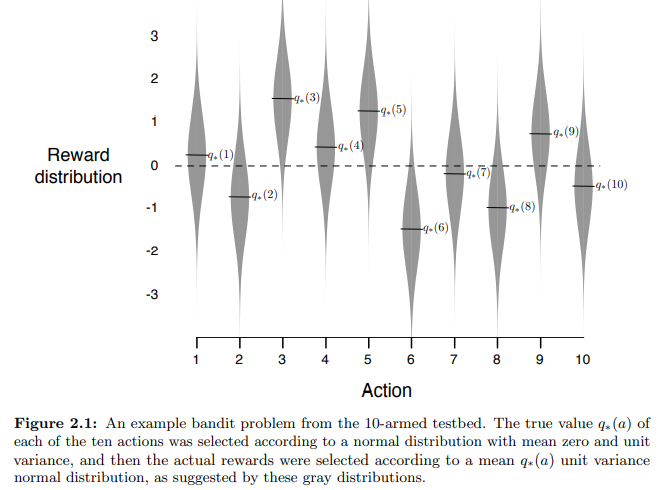

{'bodies': [<matplotlib.collections.PolyCollection at 0x7c1010dde470>,
 'cmeans': <matplotlib.collections.LineCollection at 0x7c1010dde500>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7c1010dc9510>,
 'cmins': <matplotlib.collections.LineCollection at 0x7c1010dcbfa0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7c1010dcb880>}

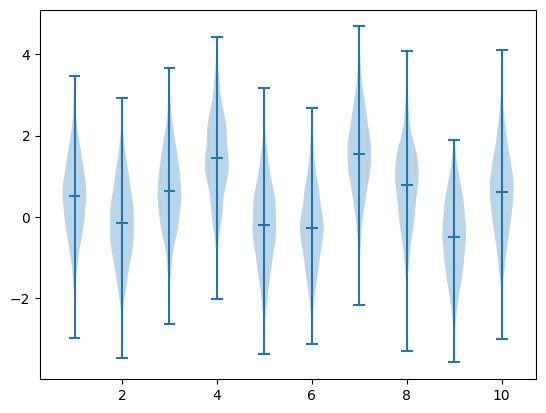

In [ ]:
# your code here
import matplotlib.pyplot as plt

plt.violinplot([results[i] for i in range(10)], showmeans=True)

## Exercise 2: Epsilon-greedy versus UCB: which is better?

Let us create a simulation study where we can precisely measure the performance of our algorithms. The objective is to compare epsilon greedy with UCB, and make a plot similar to S&B p36.

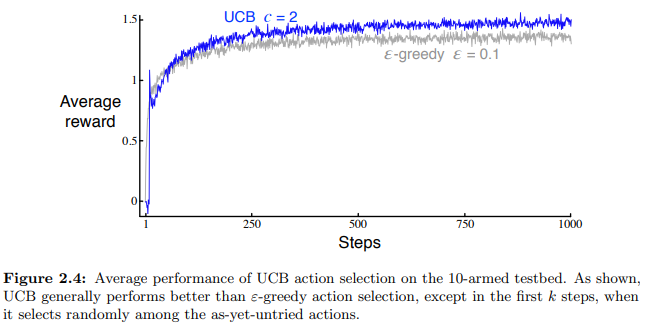

First, think about what you expect based on how the algorithms work. Which will reach the highest reward in the long run?



## Implementation of Epsilon-Greedy

In [ ]:
def epsilon_greedy(q, epsilon):
  """Epsilon-greedy policy: selects the maximum value action with probability
  (1-epsilon) and selects randomly with epsilon probability.

  Args:
    q (ndarray): an array of action values
    epsilon (float): probability of selecting an action randomly

  Returns:
    int: the chosen action
  """
  # write a boolean expression that determines if we should take the best action
  be_greedy = np.random.random() > epsilon

  if be_greedy:

    # write an expression for selecting the best action from the action values
    action = np.argmax(q)

  else:

    # write an expression for selecting a random action
    action = np.random.choice(len(q))

  return action




This is what we should expect, that the action with the largest value (action 1) is selected about (1-ε) of the time, or 90% for ε = 0.1 , and the remaining 10% is split evenly amongst the other options. Use the demo below to explore how changing affects the distribution of selected actions.

Epsilon is our one parameter for balancing exploitation and exploration.
When epsilon is zero, the agent always chooses the currently best option; it becomes greedy. When epsilon is 1, the agent chooses randomly.

epsilon = 0 => No exploration, always greedy

epsilon = 1 => Explore at every time step by taking a random action

a) Run the epsilon greedy algorithm for a 1000 steps. Store all rewards in a numpy array of size [1000].




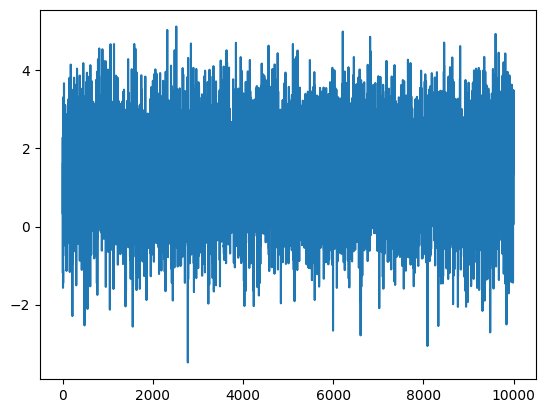

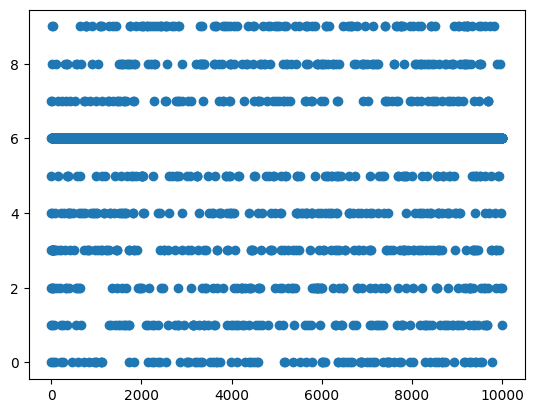

In [ ]:
q = np.zeros(10)
epsilon = 0.1
rewards_epsilon_greedy = np.zeros(10000)


# YOUR CODE HERE
n_steps = 10000

q_list = [[] for i in range(10)]
actions = []
for step in range(n_steps):
  a = epsilon_greedy(q, epsilon)
  actions.append(a)
  # print(a)
  r = env.step(a)[1]
  rewards_epsilon_greedy[step] = r
  q_list[a].append(r)
  # print(q_list)
  q = np.array([np.mean(q_list[bandit]) for bandit in range(10)])
  # print(q)

plt.plot(rewards_epsilon_greedy[:n_steps])
plt.show()
plt.close()
plt.scatter(range(n_steps), actions)

Do the same with UCB

Implement UCB


In [ ]:
def UCB(karms, q, N):
  """UCB policy: selects the arm /action with the formula :
      arm/action = argmax_a[Q(a) + sqrt(2log(t)/N(a))]
      N(a): is the number of times the arm was pulled
      t: is the total number of rounds
  Args:
    q (ndarray): an array of action values
    karms (int): number of arms
    N (ndarray): the number of times the arm was pulled
  Returns:
    int: the chosen action
  """
  t = np.sum(N)
  return np.argmax(q + np.sqrt(2*np.log(t)/N))


a) Run the ucb algorithm for 1000 steps. Store all rewards in a numpy array of size [1000].

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-33-7a02adc83cf0>:14: RuntimeWarning: divide by zero encountered in log
  return np.argmax(q + np.sqrt(2*np.log(t)/N))
<ipython-input-33-7a02adc83cf0>:14: RuntimeWarning: invalid value encountered in sqrt
  return np.argmax(q + np.sqrt(2*np.log(t)/N))
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-33-7a02adc83cf0>:14: RuntimeWarning: inv

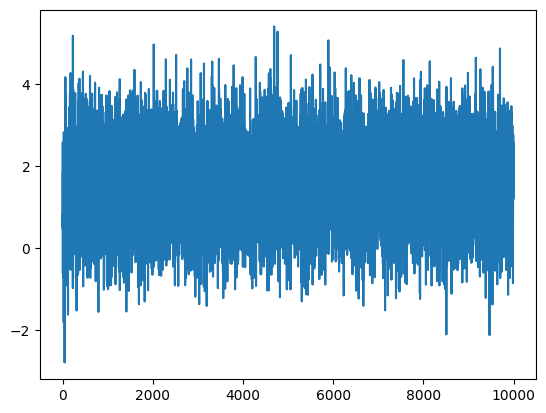

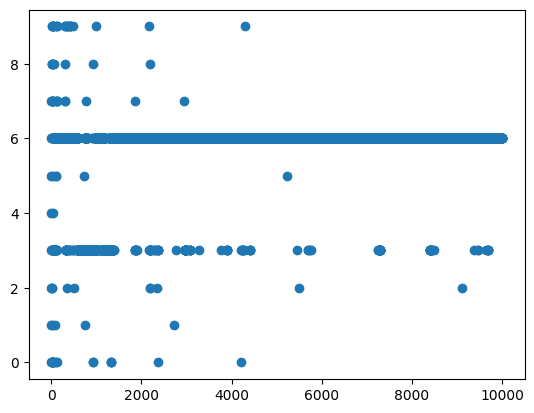

In [ ]:
q = np.zeros(10) # initial q
N = np.zeros(10) # the number of times the arm was pulled
rewards_ucb = np.zeros(10000)
# YOUR CODE HERE
n_steps = 10000

q_list = [[] for i in range(10)]
actions = []
for step in range(n_steps):
  a = UCB(10, q, np.array([len(l) for l in q_list]))
  actions.append(a)
  # print(a)
  r = env.step(a)[1]
  rewards_ucb[step] = r
  q_list[a].append(r)
  # print(q_list)
  q = np.array([np.mean(q_list[bandit]) for bandit in range(10)])
  # print(q)

plt.plot(rewards_ucb[:n_steps])
plt.show()
plt.close()
plt.scatter(range(n_steps), actions)



b) Plot the rewards as a function of time steps for both algorithms in a single plot or two plots. (similar to the plot before)

Which one performs better? What performance criterium did you use?


In [ ]:
# helper function
def averagewindow(R, d=1):
    n = len(R)
    t = []
    y = []
    for i in range(0,int(n/d)):
        t.append(np.mean(range(i*d,(i+1)*d)));
        y.append(np.mean(R[i*d:min(n,(i+1)*d)]))
    return t,y

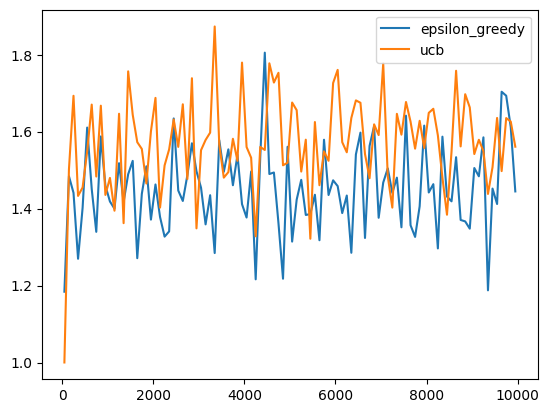

In [ ]:
t1, averaged_epsilon_greedy = averagewindow(rewards_epsilon_greedy, d=100)
t2, averaged_ucb = averagewindow(rewards_ucb, d=100)

plt.plot(t1, averaged_epsilon_greedy, label='epsilon_greedy')
plt.plot(t2, averaged_ucb, label='ucb')
plt.legend()